# 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd

import random

from tqdm.auto import tqdm
from sklearn.model_selection import StratifiedKFold

import os
from glob import glob

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler

# 환경 설정하기

In [2]:
# GPU 할당
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print(device)

cuda


In [3]:
# 하이퍼파라미터 튜닝
CFG = {
    'IMG_SIZE': 128,
    'EPOCHS': 5,
    'LEARNING_RATE': 2e-2,
    'BATCH_SIZE': 16,
    'SEED': 41
}

In [4]:
# random seed 고정
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

# 데이터 불러오기 & 처리하기

In [5]:
path = '/content/drive/MyDrive/Colab Notebooks/data/'

In [6]:
label_df = pd.read_csv(path + 'trans_train.csv').drop(columns='Unnamed: 0')

label_df.head()

,file_name,label
0,001.png,0
1,002.png,10
2,003.png,3
3,004.png,8
4,005.png,9


In [7]:
# image, label 리스트 만들기
def get_train_data(data_dir):
  label_list = []

  # get image path
  img_path_list = glob(os.path.join(data_dir, '*.png'))
  img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

  # get label
  label_list.extend(label_df['label'])

  return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, '*.png'))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

    
    return img_path_list

In [8]:
all_img_path, all_label = get_train_data(path + 'train/')
test_img_path = get_test_data(path + 'test/')

# split data

In [34]:
skfolds = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# augmentation 정의하기

In [9]:
import albumentations as A
from albumentations.pytorch.transforms import ToTensor

In [10]:
# image = cv2.imread(all_img_path[0])
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(image)

In [11]:
trn_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
    A.OneOf([
            A.HorizontalFlip(p=1),
            A.RandomRotate90(p=1),
            A.VerticalFlip(p=1), 
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=1),           
    ], p=1),
    A.OneOf([
            A.MotionBlur(p=1),
            A.Blur(blur_limit=5, p=1),
            A.GaussNoise(p=1)                 
    ], p=1),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensor()
])

test_transform = A.Compose([
   A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
   A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
   ToTensor()
])

In [12]:
# transform = A.Compose([
#                        A.Resize(CFG['IMG_SIZE'], CFG['IMG_SIZE']),
#                        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
#                        ToTensor()
# ])

Dataset 정의하기

In [13]:
class CustomDataset(Dataset):
  def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): # 필요한 변수들을 선언
    self.transforms = transforms
    self.train_mode = train_mode
    self.img_path_list = img_path_list
    self.label_list = label_list

  def __getitem__(self, index): # index번째 data 리턴
    img_path = self.img_path_list[index]

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transforms:
      image = self.transforms(image=image)["image"]

    if self.train_mode:
      label = self.label_list[index]
      return image, label
    else:
      return image

  def __len__(self):
    return len(self.img_path_list)

In [14]:
trn_dataset = CustomDataset(all_img_path, all_label, train_mode=True, transforms=trn_transform)

# model 정의하기

In [15]:
from torchvision import models
from torchsummary import summary

In [16]:
CLASS_NUM = 11

In [17]:
class CNNclassification(torch.nn.Module):
    def __init__(self):
        super(CNNclassification, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1), #cnn layer
            nn.ReLU(), #activation function
            nn.MaxPool2d(kernel_size=2, stride=2)) #pooling layer
        
        self.fc_layer = nn.Sequential( 
            nn.Linear(3136, 11) #fully connected layer(ouput layer)
        )    
        
    def forward(self, x):
        
        x = self.layer1(x) #1층
        
        x = self.layer2(x) #2층
         
        x = self.layer3(x) #3층
        
        x = self.layer4(x) #4층
        
        x = torch.flatten(x, start_dim=1) # N차원 배열 -> 1차원 배열
        
        out = self.fc_layer(x)
        return out

In [18]:
efficientnet_b3 = models.efficientnet_b3(pretrained=False)

efficientnet_b3.fc = nn.Linear(1000, 11)

efficientnet_b3

EfficientNet(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(40, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=40, bias=False)
            (1): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(40, 10, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(10, 40, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActivation(

# train loop 정의하기

In [19]:
def train_loop(dataloader, model, loss_fn, optimizer):
  size = len(dataloader.dataset)
  model.train()

  for batch, (X, y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)

    optimizer.zero_grad() # gradient를 0으로 초기화

    # 예측
    pred = model(X)

    # 손실
    loss = loss_fn(pred, y)

    # 역전파
    loss.backward() # 예측 손실을 역전파
    optimizer.step() # 역전파 단계에서 수집된 변화도로 매개변수 조정

    if batch % 10 == 0:
      loss, current = loss.item(), batch * len(X) # dataset: 총 858개, batch_size = 16 -> 54개의 batch 존재
      print(f"loss: {loss:>7f}    [{current:>5d} / {size:>5d}]")

In [20]:
def validatation_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0
    best_acc = 0
    model.eval()

    with torch.no_grad():
      for X, y in tqdm(iter(dataloader)):
        X, y = X.to(device), y.to(device)
        logit = model(X) # [bath_size, class_nums]
        
        valid_loss += loss_fn(logit, y)
        pred = logit.argmax(dim=1, keepdim=True)  #11개의 class중 가장 값이 높은 것을 예측 label로 추출
        correct += pred.eq(y.view_as(pred)).sum().item() #예측값과 실제값이 맞으면 1 아니면 0으로 합산
      vali_acc = 100 * correct / size

      print('Vail set: Loss: {:.4f}, Accuracy: {}/{} ( {:.0f}%)\n'.format(valid_loss / len(dataloader), correct, size, 100 * correct / size))

      #베스트 모델 저장
      if best_acc < vali_acc:
        best_acc = vali_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/saved/best_model.pth') #이 디렉토리에 best_model.pth을 저장
        print('Model Saved.')

      return valid_loss.item()/len(dataloader)

# train

In [21]:
skfolds = StratifiedKFold(n_splits=5)

valid_loss_list = []

for fold, (trn_idx, val_idx) in enumerate(skfolds.split(all_img_path, all_label)):
  train_sampler = SubsetRandomSampler(trn_idx)
  valid_sampler = SubsetRandomSampler(val_idx)

  # Dataloader
  train_loader = DataLoader(trn_dataset, batch_size=CFG['BATCH_SIZE'], sampler=train_sampler)
  valid_loader = DataLoader(trn_dataset, batch_size=CFG['BATCH_SIZE'], sampler=valid_sampler)

  # 모델 정의
  # model = CNNclassification().to(device)
  model = efficientnet_b3.to(device)

  criterion = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(params = model.parameters(), lr = CFG["LEARNING_RATE"])

  print(f"+++++++++++++++++++++++ Fold: {fold + 1} / 5 +++++++++++++++++++++++")

  for i in range(1, CFG['EPOCHS'] + 1):
    print(f"Epoch {i}")
    train_loop(train_loader, model, criterion, optimizer)
    loss = validatation_loop(valid_loader, model, criterion)
    valid_loss_list.append(loss)
print("Done!")

+++++++++++++++++++++++ Fold: 1 / 5 +++++++++++++++++++++++
Epoch 1
loss: 7.035846    [    0 /   858]
loss: 6.494968    [  160 /   858]
loss: 5.657956    [  320 /   858]
loss: 5.034776    [  480 /   858]
loss: 4.303699    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 6.2781, Accuracy: 16/858 ( 2%)

Model Saved.
Epoch 2
loss: 4.136074    [    0 /   858]
loss: 3.547352    [  160 /   858]
loss: 3.269813    [  320 /   858]
loss: 3.453866    [  480 /   858]
loss: 3.059302    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 36.0196, Accuracy: 22/858 ( 3%)

Model Saved.
Epoch 3
loss: 2.977130    [    0 /   858]
loss: 3.057567    [  160 /   858]
loss: 3.139391    [  320 /   858]
loss: 2.964033    [  480 /   858]
loss: 2.739994    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 18.6538, Accuracy: 16/858 ( 2%)

Model Saved.
Epoch 4
loss: 3.055761    [    0 /   858]
loss: 2.661579    [  160 /   858]
loss: 2.520860    [  320 /   858]
loss: 2.858670    [  480 /   858]
loss: 2.715455    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 6.3225, Accuracy: 29/858 ( 3%)

Model Saved.
Epoch 5
loss: 2.429633    [    0 /   858]
loss: 2.506868    [  160 /   858]
loss: 2.787611    [  320 /   858]
loss: 2.500066    [  480 /   858]
loss: 2.530247    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 10.2207, Accuracy: 30/858 ( 3%)

Model Saved.
Done!
+++++++++++++++++++++++ Fold: 2 / 5 +++++++++++++++++++++++
Epoch 1
loss: 2.504329    [    0 /   858]
loss: 2.722315    [  160 /   858]
loss: 2.496998    [  320 /   858]
loss: 2.227440    [  480 /   858]
loss: 2.258241    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 4.1392, Accuracy: 22/858 ( 3%)

Model Saved.
Epoch 2
loss: 2.516940    [    0 /   858]
loss: 2.416424    [  160 /   858]
loss: 2.484471    [  320 /   858]
loss: 2.046910    [  480 /   858]
loss: 2.295799    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 13.4187, Accuracy: 34/858 ( 4%)

Model Saved.
Epoch 3
loss: 2.761469    [    0 /   858]
loss: 2.156955    [  160 /   858]
loss: 2.080950    [  320 /   858]
loss: 2.228543    [  480 /   858]
loss: 2.512143    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 41.5518, Accuracy: 26/858 ( 3%)

Model Saved.
Epoch 4
loss: 2.507325    [    0 /   858]
loss: 1.955496    [  160 /   858]
loss: 1.978992    [  320 /   858]
loss: 2.496897    [  480 /   858]
loss: 2.237595    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 4.5845, Accuracy: 28/858 ( 3%)

Model Saved.
Epoch 5
loss: 1.947235    [    0 /   858]
loss: 2.013048    [  160 /   858]
loss: 2.444767    [  320 /   858]
loss: 2.043584    [  480 /   858]
loss: 2.412821    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.8060, Accuracy: 43/858 ( 5%)

Model Saved.
Done!
+++++++++++++++++++++++ Fold: 3 / 5 +++++++++++++++++++++++
Epoch 1
loss: 1.898063    [    0 /   858]
loss: 2.191229    [  160 /   858]
loss: 1.746479    [  320 /   858]
loss: 2.207133    [  480 /   858]
loss: 2.428853    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 6.5471, Accuracy: 48/858 ( 6%)

Model Saved.
Epoch 2
loss: 2.406614    [    0 /   858]
loss: 2.273958    [  160 /   858]
loss: 2.371251    [  320 /   858]
loss: 1.952074    [  480 /   858]
loss: 2.216639    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.9886, Accuracy: 42/858 ( 5%)

Model Saved.
Epoch 3
loss: 2.041816    [    0 /   858]
loss: 1.948135    [  160 /   858]
loss: 1.772717    [  320 /   858]
loss: 1.786505    [  480 /   858]
loss: 2.151946    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 37.8262, Accuracy: 53/858 ( 6%)

Model Saved.
Epoch 4
loss: 1.757290    [    0 /   858]
loss: 2.544878    [  160 /   858]
loss: 1.757417    [  320 /   858]
loss: 1.827546    [  480 /   858]
loss: 2.243026    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 6.8024, Accuracy: 42/858 ( 5%)

Model Saved.
Epoch 5
loss: 1.975870    [    0 /   858]
loss: 1.972089    [  160 /   858]
loss: 2.286964    [  320 /   858]
loss: 1.874297    [  480 /   858]
loss: 2.291692    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 36.6364, Accuracy: 44/858 ( 5%)

Model Saved.
Done!
+++++++++++++++++++++++ Fold: 4 / 5 +++++++++++++++++++++++
Epoch 1
loss: 2.008713    [    0 /   858]
loss: 1.754225    [  160 /   858]
loss: 1.475998    [  320 /   858]
loss: 1.809921    [  480 /   858]
loss: 1.840036    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 3.4411, Accuracy: 55/858 ( 6%)

Model Saved.
Epoch 2
loss: 2.249495    [    0 /   858]
loss: 1.810770    [  160 /   858]
loss: 1.600870    [  320 /   858]
loss: 1.451402    [  480 /   858]
loss: 1.957982    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 1.6899, Accuracy: 61/858 ( 7%)

Model Saved.
Epoch 3
loss: 1.654094    [    0 /   858]
loss: 1.554721    [  160 /   858]
loss: 2.012846    [  320 /   858]
loss: 1.438502    [  480 /   858]
loss: 1.727340    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 27.5864, Accuracy: 51/858 ( 6%)

Model Saved.
Epoch 4
loss: 1.711414    [    0 /   858]
loss: 2.056432    [  160 /   858]
loss: 1.437809    [  320 /   858]
loss: 1.623246    [  480 /   858]
loss: 1.740338    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 3.9498, Accuracy: 63/858 ( 7%)

Model Saved.
Epoch 5
loss: 1.496590    [    0 /   858]
loss: 1.571532    [  160 /   858]
loss: 1.315796    [  320 /   858]
loss: 1.737085    [  480 /   858]
loss: 1.547720    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 9.5171, Accuracy: 52/858 ( 6%)

Model Saved.
Done!
+++++++++++++++++++++++ Fold: 5 / 5 +++++++++++++++++++++++
Epoch 1
loss: 1.654311    [    0 /   858]
loss: 2.105002    [  160 /   858]
loss: 1.465436    [  320 /   858]
loss: 1.694625    [  480 /   858]
loss: 1.730744    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.6943, Accuracy: 73/858 ( 9%)

Model Saved.
Epoch 2
loss: 1.917006    [    0 /   858]
loss: 2.183455    [  160 /   858]
loss: 1.861985    [  320 /   858]
loss: 1.440522    [  480 /   858]
loss: 1.197529    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 1.6946, Accuracy: 68/858 ( 8%)

Model Saved.
Epoch 3
loss: 1.236243    [    0 /   858]
loss: 1.650992    [  160 /   858]
loss: 1.559480    [  320 /   858]
loss: 1.764901    [  480 /   858]
loss: 1.639361    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 2.2689, Accuracy: 70/858 ( 8%)

Model Saved.
Epoch 4
loss: 1.838200    [    0 /   858]
loss: 1.355261    [  160 /   858]
loss: 1.637323    [  320 /   858]
loss: 1.656800    [  480 /   858]
loss: 1.801935    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 3.2334, Accuracy: 83/858 ( 10%)

Model Saved.
Epoch 5
loss: 1.151829    [    0 /   858]
loss: 1.449496    [  160 /   858]
loss: 1.384843    [  320 /   858]
loss: 1.768414    [  480 /   858]
loss: 1.503837    [  640 /   858]


  0%|          | 0/11 [00:00<?, ?it/s]

Vail set: Loss: 1.7927, Accuracy: 75/858 ( 9%)

Model Saved.
Done!


In [22]:
summary(model, (3, CFG['IMG_SIZE'], CFG['IMG_SIZE']))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 40, 64, 64]           1,080
       BatchNorm2d-2           [-1, 40, 64, 64]              80
              SiLU-3           [-1, 40, 64, 64]               0
            Conv2d-4           [-1, 40, 64, 64]             360
       BatchNorm2d-5           [-1, 40, 64, 64]              80
              SiLU-6           [-1, 40, 64, 64]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12           [-1, 40, 64, 64]               0
           Conv2d-13           [-1, 24, 64, 64]             960
      BatchNorm2d-14           [-1, 24,

In [23]:
valid_loss_list

[6.278100447221235,
 36.019622802734375,
 18.653846047141336,
 6.322523637251421,
 10.220671220259232,
 4.139161890203303,
 13.41871365633878,
 41.55175226384943,
 4.584526062011719,
 2.805990392511541,
 6.547086542302912,
 2.9885794899680396,
 37.82618574662642,
 6.802370938387784,
 36.6363691850142,
 3.4411229220303623,
 1.6899353374134412,
 27.58643410422585,
 3.9497867931019175,
 9.517057939009232,
 2.694291028109464,
 1.694626201282848,
 2.2688893404873935,
 3.233377630060369,
 1.7927355332808061]

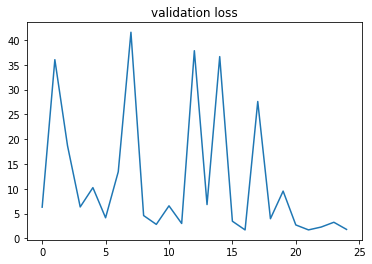

In [24]:
x_values = list(range(len(valid_loss_list)))
y_values = valid_loss_list

plt.title("validation loss")
plt.plot(x_values, y_values)
plt.show()

# 추론하기

In [25]:
def predict(model, test_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        for img in tqdm(iter(test_loader)):
            img = img.to(device)

            pred_logit = model(img)
            pred_logit = pred_logit.argmax(dim=1, keepdim=True).squeeze(1)

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [28]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Accuracy가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/saved/best_model.pth')
# model = CNNclassification().to(device)
model = efficientnet_b3.to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, device)
preds[0:5]

  0%|          | 0/14 [00:00<?, ?it/s]

[1, 1, 1, 9, 9]

# 제출하기

In [29]:
submission = pd.read_csv(path + 'sample_submission.csv')
submission['label'] = preds

In [30]:
submission['label'][submission['label'] == 10] = '10-1' ## label : 10 -> '10-1'
submission['label'][submission['label'] == 0] = '10-2' ## Label : 0 -> '10-2'
submission['label'] = submission['label'].apply(lambda x : str(x)) ## Dtype : int -> object

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [31]:
submission.head()

,file_name,label
0,001.png,1
1,002.png,1
2,003.png,1
3,004.png,9
4,005.png,9


In [32]:
submission.to_csv(path+'submit2.csv', index=False)